# TADI TP - Scale space
## Master M2 IMA Sorbonne Université 2024/25
### Carlos GRUSS and Oussama RCHAKI

### Imports

In [ ]:
import os
from google.colab import drive
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from PIL import Image
from numpy import gradient
import shutil
from scipy.ndimage import convolve
import sys

### Data loading

In [ ]:
# Name of the tgz file to be downloaded
filename = "data.tgz"

if not os.path.exists(filename):
    print(f"'{filename}' not found locally. Downloading from Google Drive...")

    # Install gdown if it's not already installed
    !pip install --quiet gdown

    # Replace 'YOUR_FILE_ID' with the actual file ID from your shareable link.
    file_id = "1cRZkqG8K6pBvl1lbNVS44d2Z0FeRoSYA"

    # Construct the download URL
    download_url = f"https://drive.google.com/uc?id={file_id}"

    # Use gdown to download the file
    import gdown
    gdown.download(download_url, filename, quiet=False)

    print("Download complete.")
else:
    print(f"'{filename}' already exists in the working environment.")


'data.tgz' not found locally. Downloading from Google Drive...


Downloading...
From: https://drive.google.com/uc?id=1cRZkqG8K6pBvl1lbNVS44d2Z0FeRoSYA
To: /content/data.tgz
100%|██████████| 2.87M/2.87M [00:00<00:00, 29.4MB/s]

Download complete.


In [ ]:
# Unzip data.tgz
!tar -xf data.tgz

In [ ]:
# Copy file from ./python/middlebury.py to pwd
shutil.copy("./python/middlebury.py", ".")

'./middlebury.py'

### Auxiliary functions

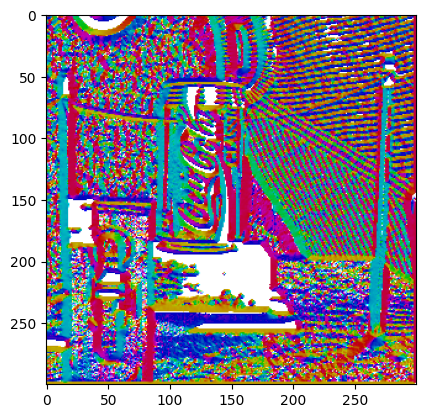

In [ ]:
from middlebury import computeColor

nasa = Image.open("./data/nasa/nasa10.png")
Ix, Iy = gradient(nasa)

# Stack Ix and Iy to create a 3-dimensional array
# This mimics the structure expected by computeColor,
# with Ix and Iy acting as the first two channels.
stacked_gradient = np.stack((Ix, Iy, np.zeros_like(Ix)), axis=-1)

plt.imshow(computeColor(stacked_gradient))
plt.show()

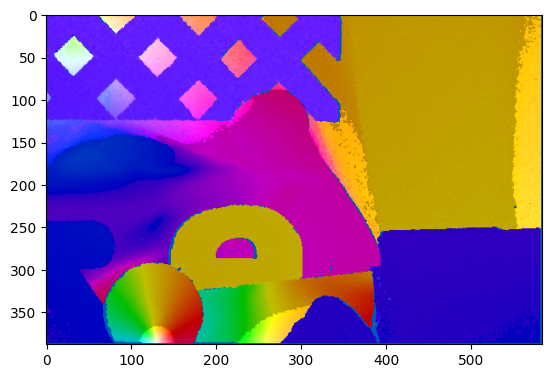

In [ ]:
def readflo(path):
  with open(path, 'rb') as f:
    magic = np.fromfile(f, np.float32, count=1)
    if 202021.25 != magic:
        print('Magic number incorrect. Invalid .flo file')
        return None
    else:
        w = np.fromfile(f, np.int32, count=1)[0]
        h = np.fromfile(f, np.int32, count=1)[0]
        #print('Reading %d x %d flo file' % (w, h))
        data = np.fromfile(f, np.float32, count=2*w*h)
        # Reshape data into 3D array (columns, rows, bands)
        data2D = np.resize(data, (h, w, 2))
        return data2D

# Test
flo = readflo('/content/data/rubberwhale/correct_rubberwhale10.flo')
plt.imshow(computeColor(flo))
plt.show()

In [ ]:
def displayMVF(I, mvf, subsamp, Bool = False, scale_factor = 1.0, ax=None): # quiver()
    """
    Display a motion vector field on an image.

    Parameters
    ----------
    I : ndarray
        The background image (grayscale).
    mvf : ndarray
        The dense motion vector field with shape (rows, cols, 2).
    subsamp : int
        The subsampling factor for the motion vectors.
    scale_factor : float, optional
        Scaling factor for the vectors' magnitude.
    ax : matplotlib.axes.Axes, optional
        The axis on which to plot. If None, a new figure and axis will be created.
    """
    row, col = np.shape(I)

    # Subsample dense MVF
    vectRow = mvf[0:row:subsamp, 0:col:subsamp, 0] * scale_factor
    vectCol = mvf[0:row:subsamp, 0:col:subsamp, 1] * scale_factor

    # Determine vector origins
    X, Y = np.meshgrid(np.arange(0, col, subsamp), np.arange(0, row, subsamp))
    X = X + np.floor(subsamp / 2.)
    Y = Y + np.floor(subsamp / 2.)

    # If no axis is provided, create one
    if ax is None:
        fig, ax = plt.subplots()

    # Plot the image and overlay the motion vectors
    ax.imshow(I, cmap='gray')
    ax.set_title('Motion Vector Field')
    if Bool :
      ax.quiver(X, Y, vectCol, -vectRow, color='r', scale=scale_factor)
    else :
      ax.quiver(X, Y, vectCol, -vectRow, color='r')


    return ax

### Horn-Schunck

In [ ]:
def gradhorn(I1, I2):
    """
    Compute the spatiotemporal gradients between two images using Horn & Schunck's filter.

    Parameters
    ----------
    I1 : np.ndarray
        First grayscale image of size (H, W).
    I2 : np.ndarray
        Second grayscale image of size (H, W).

    Returns
    -------
    Ix : np.ndarray
        Approximate spatial gradient in the x-direction (size: (H-1, W-1)).
    Iy : np.ndarray
        Approximate spatial gradient in the y-direction (size: (H-1, W-1)).
    It : np.ndarray
        Approximate temporal gradient (size: (H-1, W-1)).

    The gradients are computed as follows:

    I_x(i, j) ≈ 1/4 * [ (I1(i, j+1) - I1(i, j)) + (I1(i+1, j+1) - I1(i+1, j)) +
                         (I2(i, j+1) - I2(i, j)) + (I2(i+1, j+1) - I2(i+1, j)) ]

    I_y(i, j) ≈ 1/4 * [ (I1(i+1, j) - I1(i, j)) + (I1(i+1, j+1) - I1(i, j+1)) +
                         (I2(i+1, j) - I2(i, j)) + (I2(i+1, j+1) - I2(i, j+1)) ]

    I_t(i, j) ≈ 1/4 * [ (I2(i, j) - I1(i, j)) + (I2(i+1, j) - I1(i+1, j)) +
                         (I2(i, j+1) - I1(i, j+1)) + (I2(i+1, j+1) - I1(i+1, j+1)) ]
    """
    # Convert images to float (if they are not already) to avoid integer arithmetic
    I1 = I1.astype(np.float32)
    I2 = I2.astype(np.float32)

    # Compute I_x using the 2x2 neighborhood differences
    Ix = 0.25 * (
        (I1[:-1, 1:] - I1[:-1, :-1]) +
        (I1[1:, 1:]  - I1[1:, :-1]) +
        (I2[:-1, 1:] - I2[:-1, :-1]) +
        (I2[1:, 1:]  - I2[1:, :-1])
    )

    # Compute I_y using the 2x2 neighborhood differences
    Iy = 0.25 * (
        (I1[1:, :-1] - I1[:-1, :-1]) +
        (I1[1:, 1:]  - I1[:-1, 1:]) +
        (I2[1:, :-1] - I2[:-1, :-1]) +
        (I2[1:, 1:]  - I2[:-1, 1:])
    )

    # Compute I_t using the differences between I2 and I1
    It = 0.25 * (
        (I2[:-1, :-1] - I1[:-1, :-1]) +
        (I2[1:, :-1]  - I1[1:, :-1]) +
        (I2[:-1, 1:]  - I1[:-1, 1:]) +
        (I2[1:, 1:]   - I1[1:, 1:])
    )

    return Ix, Iy, It

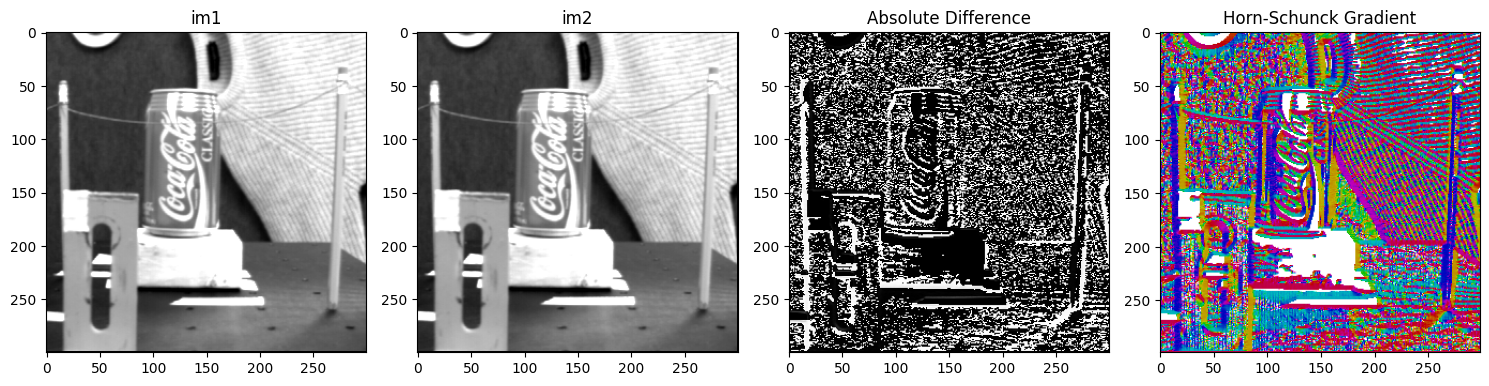

In [ ]:
# Load images im1 and im2
# ex: /data/nasa/nasa10.png and /data/nasa/nasa9.png

im1 = cv2.imread('/content/data/nasa/nasa10.png', cv2.IMREAD_GRAYSCALE)
im2 = cv2.imread('/content/data/nasa/nasa9.png', cv2.IMREAD_GRAYSCALE)

fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Plot im1
axs[0].imshow(im1, cmap='gray')
axs[0].set_title('im1')

# Plot im2
axs[1].imshow(im2, cmap='gray')
axs[1].set_title('im2')

# Plot absolute difference
diff = np.abs(im2 - im1)
axs[2].imshow(diff, cmap='gray')
axs[2].set_title('Absolute Difference')

# Plot the result of the gradhorn image
Ix, Iy, It = gradhorn(im1, im2)
axs[3].imshow(computeColor(np.stack((Ix, Iy, It), axis=-1)), cmap='gray')
axs[3].set_title('Horn-Schunck Gradient')

plt.tight_layout()
plt.show()

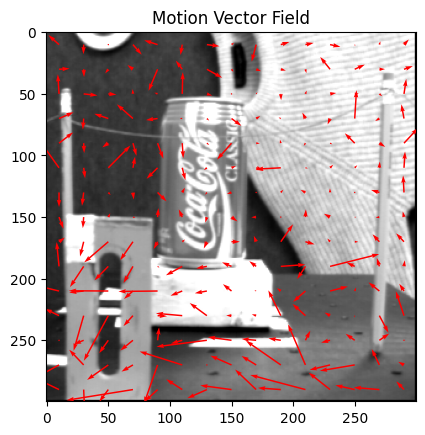

In [ ]:
def horn(I1, I2, alpha=1.0, N=100):
    """ Compute optical flow using the Horn-Schunck method. """
    Ix, Iy, It = gradhorn(I1, I2)

    # Adjust the initialization of u and v to match the size of Ix, Iy, and It
    u = np.zeros_like(Ix)
    v = np.zeros_like(Ix)

    kernel = np.array([[1/12, 1/6, 1/12],
                        [1/6, 0, 1/6],
                        [1/12, 1/6, 1/12]])

    for _ in range(N):
        u_avg = cv2.filter2D(u, -1, kernel, borderType=cv2.BORDER_REPLICATE)  # Handle borders
        v_avg = cv2.filter2D(v, -1, kernel, borderType=cv2.BORDER_REPLICATE)  # Handle borders

        num = Ix * u_avg + Iy * v_avg + It
        den = alpha + Ix**2 + Iy**2

        u = u_avg - (Ix * num / den)
        v = v_avg - (Iy * num / den)

    # Pad the output to match the original image size
    u = np.pad(u, ((0, 1), (0, 1)), mode='edge')
    v = np.pad(v, ((0, 1), (0, 1)), mode='edge')

    return u, v

# Example usage with two sample images
I1 = cv2.imread('/content/data/nasa/nasa10.png', cv2.IMREAD_GRAYSCALE)
I2 = cv2.imread('/content/data/nasa/nasa9.png', cv2.IMREAD_GRAYSCALE)

u, v = horn(I1, I2, alpha=1.0, N=100)

# Use displayMVF
displayMVF(I1, np.stack((u, v), axis=-1), 20, False)
plt.show()

In [ ]:
def compute_errors(REF, HS):
    """ Compute angular error, norm error, and end-point error. """
    supp = 1 + REF[:,:,0] * HS[:,:,0] + REF[:,:,1] * HS[:,:,1]
    inf = (np.sqrt(1 + REF[:,:,0]**2 + REF[:,:,1]**2) *
           np.sqrt(1 + HS[:,:,0]**2 + HS[:,:,1]**2))
    cos = np.rad2deg(np.arccos(np.clip(supp / inf, -1, 1)))
    mean_ang, std_ang = np.mean(cos), np.std(cos)

    norm_diff = np.abs(REF) - np.abs(HS)
    mean_norm, std_norm = norm_diff.mean(), norm_diff.std()

    epe_dist = np.abs(REF - HS)
    mean_epe, std_epe = epe_dist.mean(), epe_dist.std()

    return (mean_ang, std_ang), (mean_norm, std_norm), (mean_epe, std_epe)

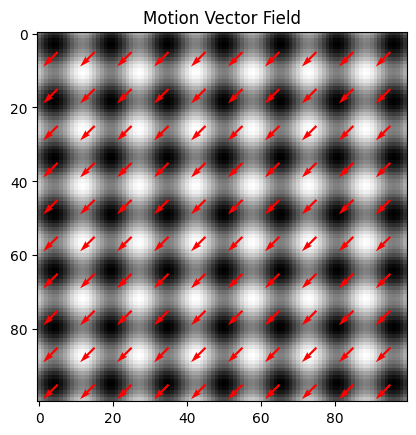

Mean Error: (0.007686217, 0.01962881), Standard Deviation: (0.0001567287, 0.00055416714), Angular Error: (0.0002728707, 0.0005071555)


In [ ]:
# Example usage with two sample images
I1 = cv2.imread('/content/data/mysine/mysine9.png', cv2.IMREAD_GRAYSCALE)
I2 = cv2.imread('/content/data/mysine/mysine10.png', cv2.IMREAD_GRAYSCALE)

ground_truth = readflo('/content/data/mysine/correct_mysine.flo')

u, v = horn(I1, I2, alpha=1.0, N=100)
displayMVF(I1, np.stack((u, v), axis=-1), 10, False)
plt.show()

estimated_flow = np.stack((u, v), axis=-1)
mean_err, std_err, ang_err = compute_errors(ground_truth, estimated_flow)

print(f"Mean Error: {mean_err}, Standard Deviation: {std_err}, Angular Error: {ang_err}")


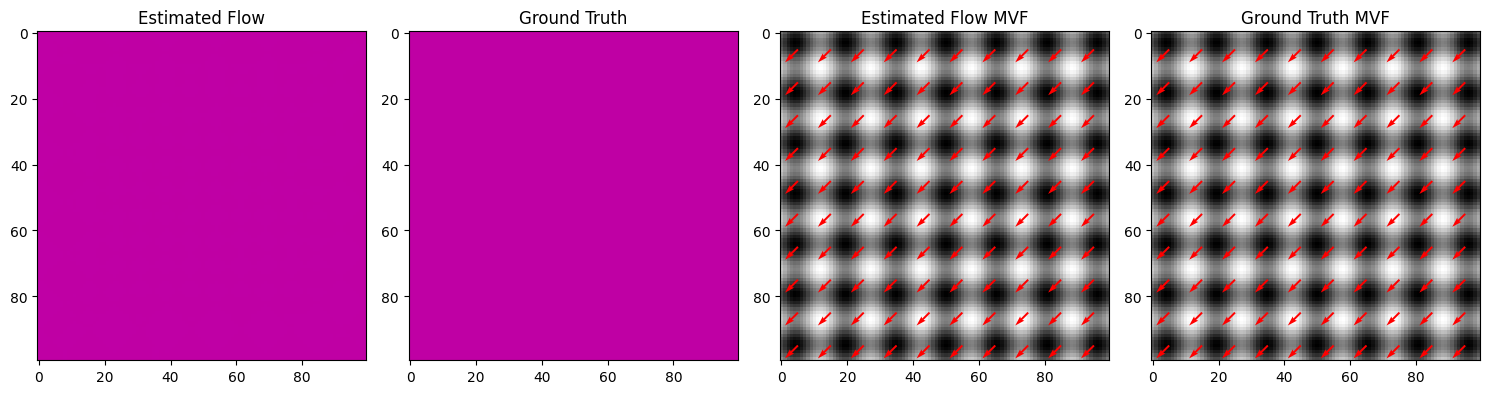

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Plot computeColor for estimated flow and ground truth flow
axs[0].imshow(computeColor(np.stack((u, v, np.zeros_like(u)), axis=-1)), cmap='gray')
axs[0].set_title('Estimated Flow')

axs[1].imshow(computeColor(np.stack((ground_truth[:,:,0], ground_truth[:,:,1], np.zeros_like(ground_truth[:,:,0])), axis=-1)), cmap='gray')
axs[1].set_title('Ground Truth')

# Plot displayMVF for estimated flow and ground truth flow

displayMVF(I1, np.stack((u, v), axis=-1), 10, False, ax=axs[2])
axs[2].set_title('Estimated Flow MVF')

displayMVF(I1, np.stack((ground_truth[:,:,0], ground_truth[:,:,1], np.zeros_like(ground_truth[:,:,0])), axis=-1), 10, False, ax=axs[3])
axs[3].set_title('Ground Truth MVF')

plt.tight_layout()
plt.show()

In [ ]:
errors = compute_errors(ground_truth, estimated_flow)

print(f"Angular Error: Mean={errors[0][0]}, Std={errors[0][1]}")
print(f"Norm Error: Mean={errors[1][0]}, Std={errors[1][1]}")
print(f"End-Point Error: Mean={errors[2][0]}, Std={errors[2][1]}")

Angular Error: Mean=0.007686216849833727, Std=0.01962880976498127
Norm Error: Mean=0.0001567286963108927, Std=0.0005541671416722238
End-Point Error: Mean=0.00027287070406600833, Std=0.0005071554915048182


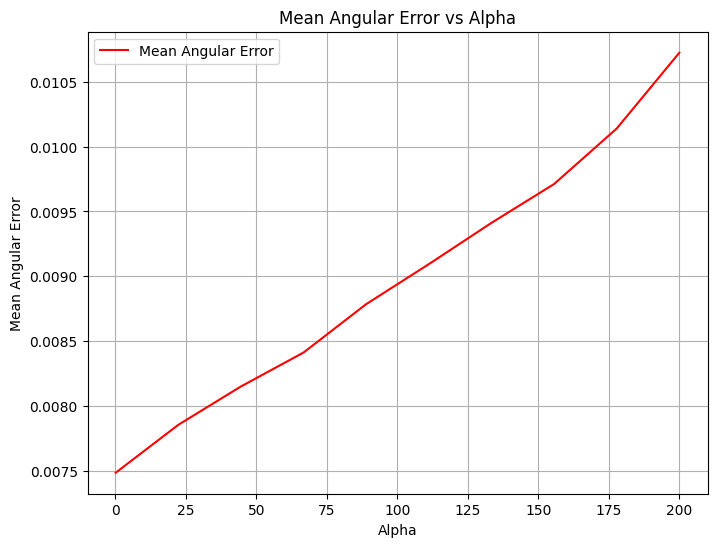

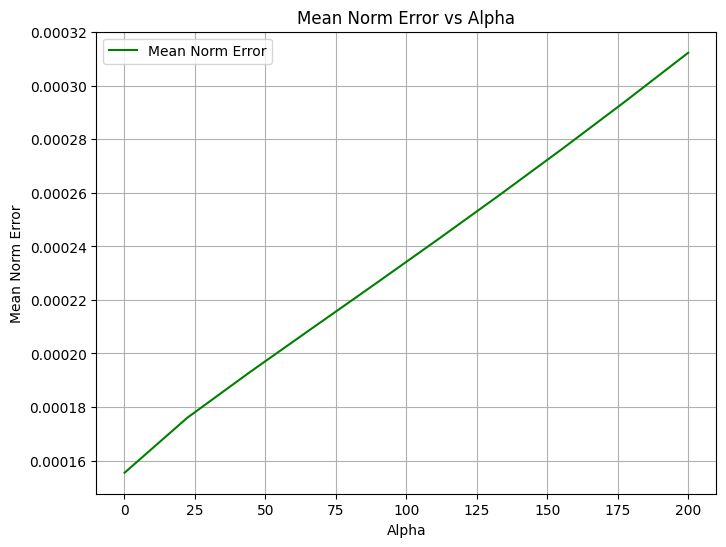

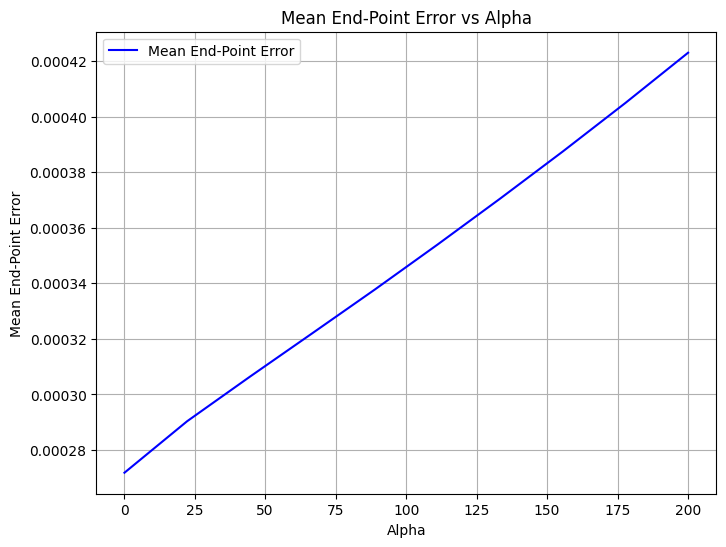

In [ ]:
# Load images
I1 = cv2.imread('/content/data/mysine/mysine9.png', cv2.IMREAD_GRAYSCALE)
I2 = cv2.imread('/content/data/mysine/mysine10.png', cv2.IMREAD_GRAYSCALE)
ground_truth = readflo('/content/data/mysine/correct_mysine.flo')

# Define alpha values
alpha_values = np.linspace(0.1, 200.0, 10)  # Adjust range as needed
mean_angular_errors = []
mean_norm_errors = []
mean_end_point_errors = []

for alpha in alpha_values:
    u, v = horn(I1, I2, alpha, N=100)
    estimated_flow = np.stack((u, v), axis=-1)
    errors = compute_errors(ground_truth, estimated_flow)

    mean_angular_errors.append(errors[0][0])
    mean_norm_errors.append(errors[1][0])
    mean_end_point_errors.append(errors[2][0])

# Plot each error separately
plt.figure(figsize=(8, 6))
plt.plot(alpha_values, mean_angular_errors, label='Mean Angular Error', color='r')
plt.xlabel('Alpha')
plt.ylabel('Mean Angular Error')
plt.title('Mean Angular Error vs Alpha')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(alpha_values, mean_norm_errors, label='Mean Norm Error', color='g')
plt.xlabel('Alpha')
plt.ylabel('Mean Norm Error')
plt.title('Mean Norm Error vs Alpha')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(alpha_values, mean_end_point_errors, label='Mean End-Point Error', color='b')
plt.xlabel('Alpha')
plt.ylabel('Mean End-Point Error')
plt.title('Mean End-Point Error vs Alpha')
plt.legend()
plt.grid()
plt.show()



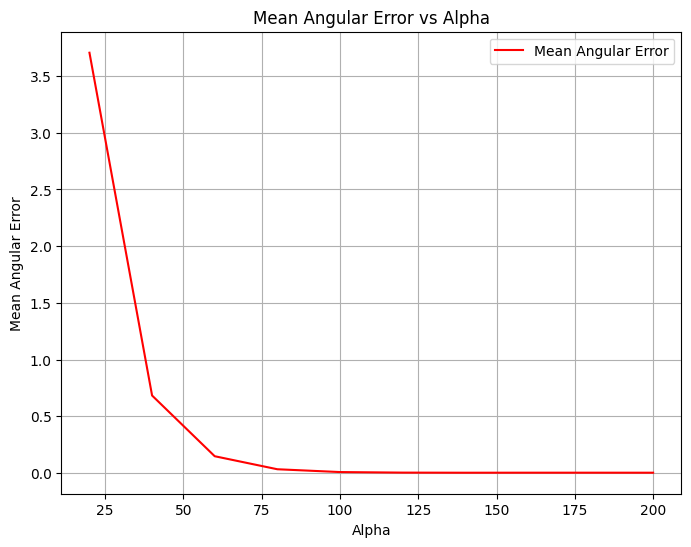

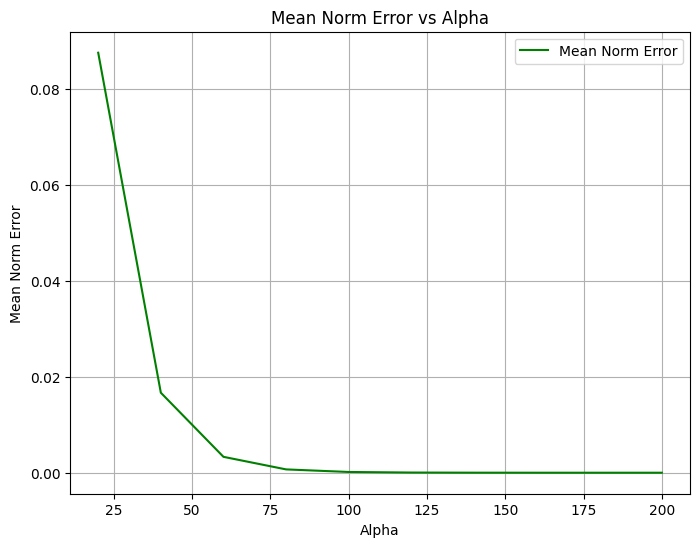

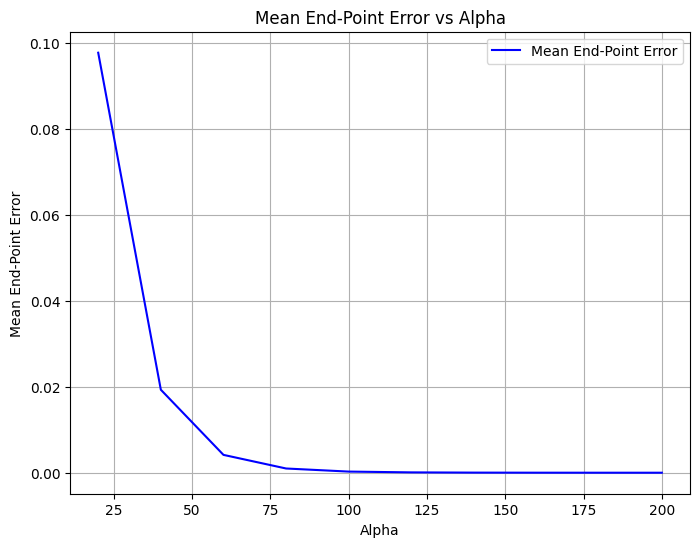

In [ ]:
# Load images
I1 = cv2.imread('/content/data/mysine/mysine9.png', cv2.IMREAD_GRAYSCALE)
I2 = cv2.imread('/content/data/mysine/mysine10.png', cv2.IMREAD_GRAYSCALE)
ground_truth = readflo('/content/data/mysine/correct_mysine.flo')

# Define alpha values
alpha_values = np.linspace(20, 200.0, 10)  # Adjust range as needed
mean_angular_errors = []
mean_norm_errors = []
mean_end_point_errors = []

for N in alpha_values:
    u, v = horn(I1, I2, 1, N = int(N))
    estimated_flow = np.stack((u, v), axis=-1)
    errors = compute_errors(ground_truth, estimated_flow)

    mean_angular_errors.append(errors[0][0])
    mean_norm_errors.append(errors[1][0])
    mean_end_point_errors.append(errors[2][0])

# Plot each error separately
plt.figure(figsize=(8, 6))
plt.plot(alpha_values, mean_angular_errors, label='Mean Angular Error', color='r')
plt.xlabel('Alpha')
plt.ylabel('Mean Angular Error')
plt.title('Mean Angular Error vs Alpha')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(alpha_values, mean_norm_errors, label='Mean Norm Error', color='g')
plt.xlabel('Alpha')
plt.ylabel('Mean Norm Error')
plt.title('Mean Norm Error vs Alpha')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(alpha_values, mean_end_point_errors, label='Mean End-Point Error', color='b')
plt.xlabel('Alpha')
plt.ylabel('Mean End-Point Error')
plt.title('Mean End-Point Error vs Alpha')
plt.legend()
plt.grid()
plt.show()



### Lucas-Kanade

In [ ]:
def lucas_kanade(I1, I2, window_size=5):
    """
    Compute optical flow using the Lucas-Kanade method.
    """
    Ix, Iy, It = gradhorn(I1, I2)
    h, w = Ix.shape
    u, v = np.zeros((h, w)), np.zeros((h, w))

    half_win = window_size // 2
    for i in range(half_win, h - half_win):
        for j in range(half_win, w - half_win):
            Ix_win = Ix[i - half_win:i + half_win + 1, j - half_win:j + half_win + 1].flatten()
            Iy_win = Iy[i - half_win:i + half_win + 1, j - half_win:j + half_win + 1].flatten()
            It_win = It[i - half_win:i + half_win + 1, j - half_win:j + half_win + 1].flatten()

            A = np.stack((Ix_win, Iy_win), axis=1)
            b = -It_win

            # Solve using least squares
            if np.linalg.cond(A.T @ A) < 1e-2:  # Avoid unstable solutions
                continue
            nu = np.linalg.pinv(A.T @ A) @ A.T @ b
            u[i, j], v[i, j] = nu[0], nu[1]
          # Pad the output to match the original image size
    u = np.pad(u, ((0, 1), (0, 1)), mode='edge')
    v = np.pad(v, ((0, 1), (0, 1)), mode='edge')

    return u, v


In [ ]:
# Example usage
I1 = cv2.imread('/content/data/mysine/mysine9.png', cv2.IMREAD_GRAYSCALE)
I2 = cv2.imread('/content/data/mysine/mysine10.png', cv2.IMREAD_GRAYSCALE)

u, v = lucas_kanade(I1, I2, 8)

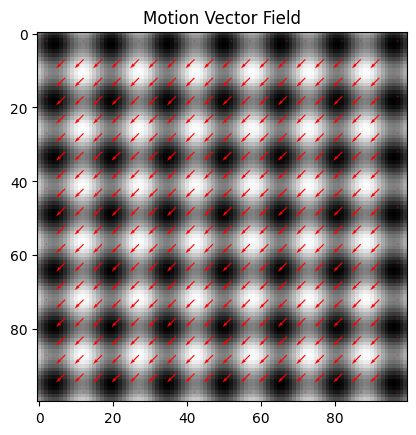

In [ ]:
# Use displayMVF
displayMVF(I1, np.stack((u, v), axis=-1), 5, False)
plt.show()

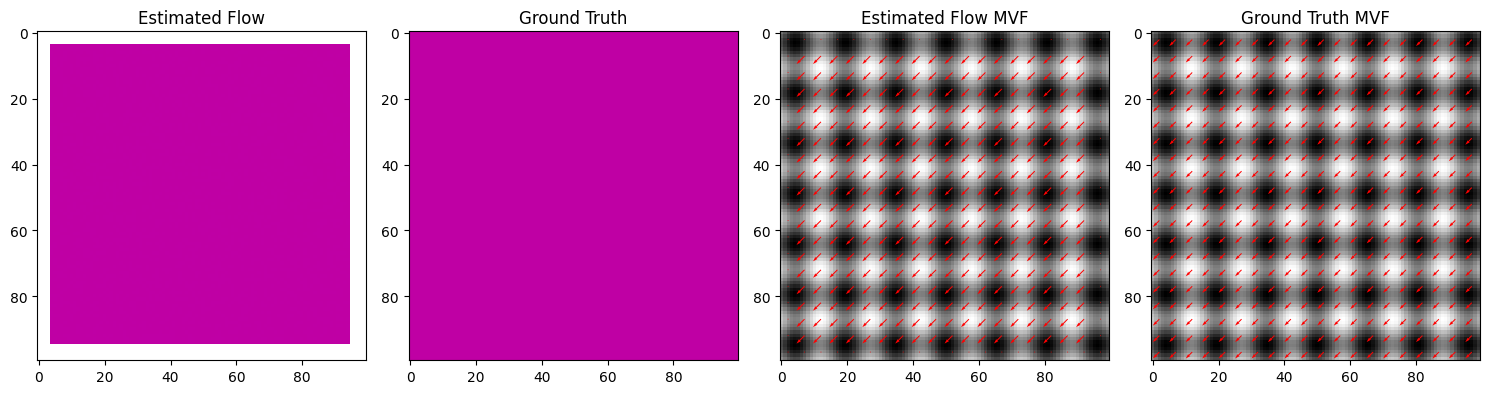

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Plot computeColor for estimated flow and ground truth flow
axs[0].imshow(computeColor(np.stack((u, v, np.zeros_like(u)), axis=-1)), cmap='gray')
axs[0].set_title('Estimated Flow')

axs[1].imshow(computeColor(np.stack((ground_truth[:,:,0], ground_truth[:,:,1], np.zeros_like(ground_truth[:,:,0])), axis=-1)), cmap='gray')
axs[1].set_title('Ground Truth')

# Plot displayMVF for estimated flow and ground truth flow

displayMVF(I1, np.stack((u, v), axis=-1), 5, False, ax=axs[2])
axs[2].set_title('Estimated Flow MVF')

displayMVF(I1, np.stack((ground_truth[:,:,0], ground_truth[:,:,1], np.zeros_like(ground_truth[:,:,0])), axis=-1), 5, False, ax=axs[3])
axs[3].set_title('Ground Truth MVF')

plt.tight_layout()
plt.show()

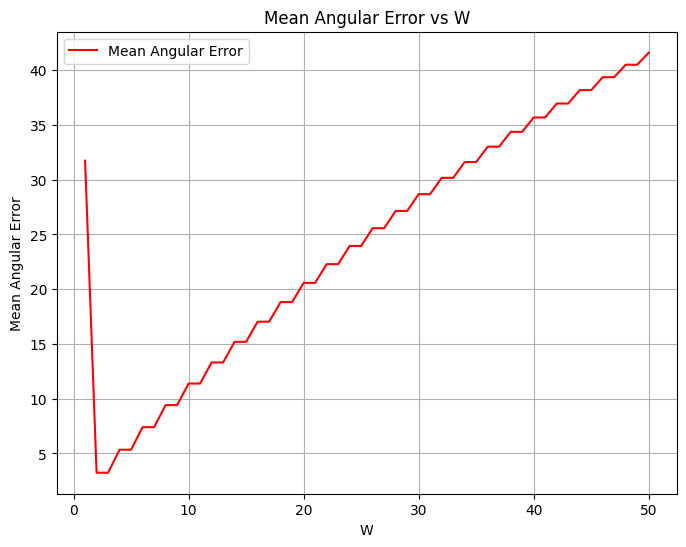

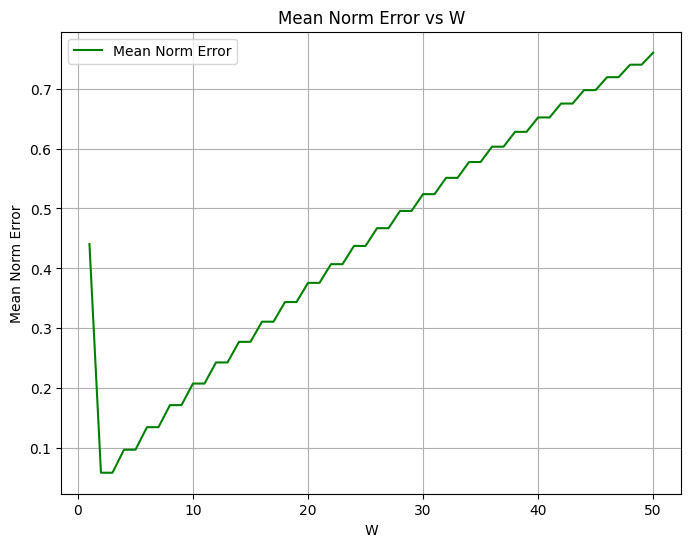

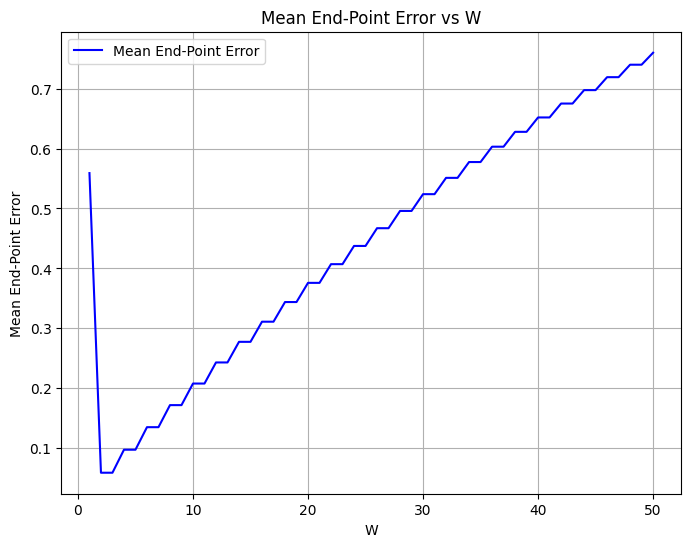

In [ ]:
# Load images
I1 = cv2.imread('/content/data/mysine/mysine9.png', cv2.IMREAD_GRAYSCALE)
I2 = cv2.imread('/content/data/mysine/mysine10.png', cv2.IMREAD_GRAYSCALE)
ground_truth = readflo('/content/data/mysine/correct_mysine.flo')

# Define alpha values
W_values = np.linspace(1, 50, 50)  # Adjust range as needed
mean_angular_errors = []
mean_norm_errors = []
mean_end_point_errors = []

for W in W_values:
    u, v = lucas_kanade(I1, I2, int(W))
    estimated_flow = np.stack((u, v), axis=-1)
    errors = compute_errors(ground_truth, estimated_flow)

    mean_angular_errors.append(errors[0][0])
    mean_norm_errors.append(errors[1][0])
    mean_end_point_errors.append(errors[2][0])

# Plot each error separately
plt.figure(figsize=(8, 6))
plt.plot(W_values, mean_angular_errors, label='Mean Angular Error', color='r')
plt.xlabel('W')
plt.ylabel('Mean Angular Error')
plt.title('Mean Angular Error vs W')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(W_values, mean_norm_errors, label='Mean Norm Error', color='g')
plt.xlabel('W')
plt.ylabel('Mean Norm Error')
plt.title('Mean Norm Error vs W')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(W_values, mean_end_point_errors, label='Mean End-Point Error', color='b')
plt.xlabel('W')
plt.ylabel('Mean End-Point Error')
plt.title('Mean End-Point Error vs W')
plt.legend()
plt.grid()
plt.show()



### Gaussian window

In [ ]:
def lucas_kanade_gaussian(I1, I2, window_size=5, sigma=1.0):
    """
    Compute optical flow using the Lucas-Kanade method with a Gaussian window.

    Parameters:
    - I1, I2: Input grayscale images
    - window_size: The size of the local window (must be odd)
    - sigma: Standard deviation of the Gaussian weighting function

    Returns:
    - u, v: Optical flow vectors
    """
    Ix, Iy, It = gradhorn(I1, I2)  # Compute image gradients
    h, w = Ix.shape
    u, v = np.zeros((h, w)), np.zeros((h, w))

    # Generate a Gaussian window
    half_win = window_size // 2
    y, x = np.mgrid[-half_win:half_win+1, -half_win:half_win+1]
    gaussian_weights = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    gaussian_weights /= gaussian_weights.sum()  # Normalize

    for i in range(half_win, h - half_win):
        for j in range(half_win, w - half_win):
            Ix_win = Ix[i - half_win:i + half_win + 1, j - half_win:j + half_win + 1] * gaussian_weights
            Iy_win = Iy[i - half_win:i + half_win + 1, j - half_win:j + half_win + 1] * gaussian_weights
            It_win = It[i - half_win:i + half_win + 1, j - half_win:j + half_win + 1] * gaussian_weights

            A = np.stack((Ix_win.flatten(), Iy_win.flatten()), axis=1)
            b = -It_win.flatten()

            # Solve using least squares
            if np.linalg.cond(A.T @ A) > 1e3:  # Avoid unstable solutions
                continue
            nu = np.linalg.pinv(A.T @ A) @ A.T @ b
            u[i, j], v[i, j] = nu[0], nu[1]

    u = np.pad(u, ((0, 1), (0, 1)), mode='edge')
    v = np.pad(v, ((0, 1), (0, 1)), mode='edge')

    return u, v


In [ ]:
# Example usage
I1 = cv2.imread('/content/data/mysine/mysine9.png', cv2.IMREAD_GRAYSCALE)
I2 = cv2.imread('/content/data/mysine/mysine10.png', cv2.IMREAD_GRAYSCALE)

u, v = lucas_kanade_gaussian(I1, I2, 8)

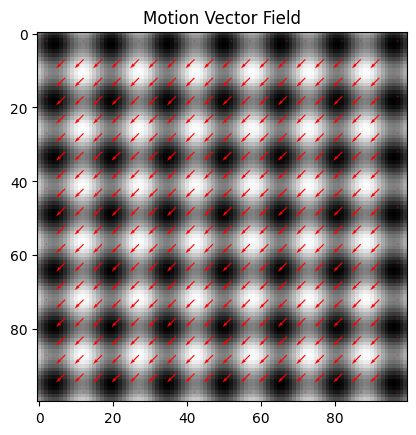

In [ ]:
# Use displayMVF
displayMVF(I1, np.stack((u, v), axis=-1), 5, False)
plt.show()

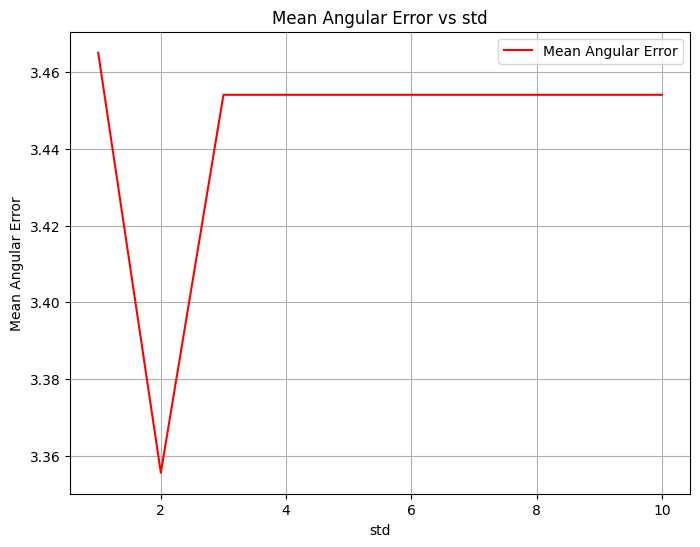

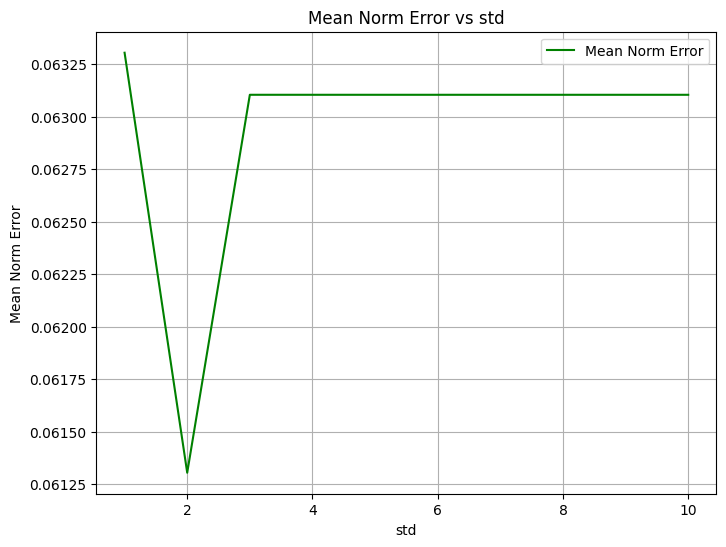

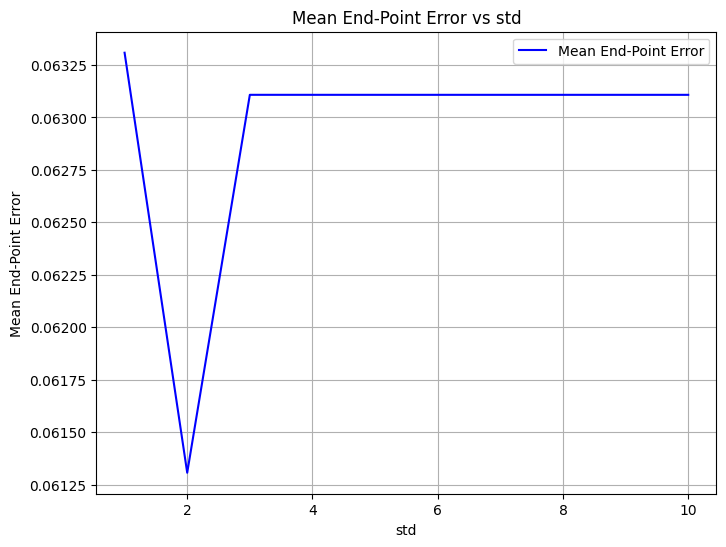

In [ ]:
# Load images
I1 = cv2.imread('/content/data/mysine/mysine9.png', cv2.IMREAD_GRAYSCALE)
I2 = cv2.imread('/content/data/mysine/mysine10.png', cv2.IMREAD_GRAYSCALE)
ground_truth = readflo('/content/data/mysine/correct_mysine.flo')

# Define alpha values
W_values = np.linspace(1, 10, 10)  # Adjust range as needed
mean_angular_errors = []
mean_norm_errors = []
mean_end_point_errors = []

for W in W_values:
    u, v = lucas_kanade_gaussian(I1, I2, 3 ,int(W) )
    estimated_flow = np.stack((u, v), axis=-1)
    errors = compute_errors(ground_truth, estimated_flow)

    mean_angular_errors.append(errors[0][0])
    mean_norm_errors.append(errors[1][0])
    mean_end_point_errors.append(errors[2][0])

# Plot each error separately
plt.figure(figsize=(8, 6))
plt.plot(W_values, mean_angular_errors, label='Mean Angular Error', color='r')
plt.xlabel('std')
plt.ylabel('Mean Angular Error')
plt.title('Mean Angular Error vs std')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(W_values, mean_norm_errors, label='Mean Norm Error', color='g')
plt.xlabel('std')
plt.ylabel('Mean Norm Error')
plt.title('Mean Norm Error vs std')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(W_values, mean_end_point_errors, label='Mean End-Point Error', color='b')
plt.xlabel('std')
plt.ylabel('Mean End-Point Error')
plt.title('Mean End-Point Error vs std')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Example usage with two sample images
I1 = cv2.imread('/content/data/mysine/mysine9.png', cv2.IMREAD_GRAYSCALE)
I2 = cv2.imread('/content/data/mysine/mysine10.png', cv2.IMREAD_GRAYSCALE)

ground_truth = readflo('/content/data/mysine/correct_mysine.flo')

# Compute Lucas-Kanade flow
u, v = lucas_kanade(I1, I2, 3)
estimated_flow = np.stack((u, v), axis=-1)

# Determine the cropping indices
h, w, _ = ground_truth.shape  # Get height and width
crop_h, crop_w = 3, 3  # Number of rows/columns to exclude from each side

# Crop images to focus only on the center
ground_truth_cropped = ground_truth[crop_h:h-crop_h, crop_w:w-crop_w, :]
estimated_flow_cropped = estimated_flow[crop_h:h-crop_h, crop_w:w-crop_w, :]

# Compute errors
mean_err, std_err, ang_err = compute_errors(ground_truth_cropped, estimated_flow_cropped)

print(f"Mean Error: {mean_err}, Standard Deviation: {std_err}, Angular Error: {ang_err}")

# Compute Lucas-Kanade Gauss flow
u, v = lucas_kanade_gaussian(I1, I2, 3, 2)
estimated_flow = np.stack((u, v), axis=-1)

# Determine the cropping indices
h, w, _ = ground_truth.shape  # Get height and width
crop_h, crop_w = 3, 3  # Number of rows/columns to exclude from each side

# Crop images to focus only on the center
ground_truth_cropped = ground_truth[crop_h:h-crop_h, crop_w:w-crop_w, :]
estimated_flow_cropped = estimated_flow[crop_h:h-crop_h, crop_w:w-crop_w, :]

# Compute errors
mean_err, std_err, ang_err = compute_errors(ground_truth_cropped, estimated_flow_cropped)

print(f"Mean Error Gauss: {mean_err}, Standard Deviation Gauss: {std_err}, Angular Error Gauss: {ang_err}")

# Compute Horn-Schunck flow
u, v = horn(I1, I2, 1)
estimated_flow = np.stack((u, v), axis=-1)

# Crop estimated flow for Horn-Schunck
estimated_flow_cropped = estimated_flow[crop_h:h-crop_h, crop_w:w-crop_w, :]

# Compute errors
mean_err, std_err, ang_err = compute_errors(ground_truth_cropped, estimated_flow_cropped)

print(f"Mean Error horny: {mean_err}, Standard Deviation horny: {std_err}, Angular Error horny: {ang_err}")


Mean Error: (0.0001542709115021489, 0.006956934551450948), Standard Deviation: (2.490956084984036e-06, 0.0002163331672599459), Angular Error: (4.805985377783579e-06, 0.00021629412064012646)
Mean Error Gauss: (0.13643336088480879, 2.7277982993019534), Standard Deviation Gauss: (0.002492316710040744, 0.049836209764489985), Angular Error Gauss: (0.0024940040558244993, 0.049836125351424815)
Mean Error horny: (0.0041047856, 0.010797902), Standard Deviation horny: (0.00010453694, 0.00030316383), Angular Error horny: (0.00018132005, 0.00026449826)


### Nagel

In [ ]:
def nagel_method(I1, I2, N, alpha, delta):
    """
    Implements the Nagel method for optical flow estimation.

    Parameters
    ----------
    I1 : np.ndarray
        First grayscale image.
    I2 : np.ndarray
        Second grayscale image.
    N : int
        Number of iterations.
    alpha : float
        Regularization parameter.
    delta : float
        Oriented regularization parameter.

    Returns
    -------
    u : np.ndarray
        Horizontal component of the estimated flow.
    v : np.ndarray
        Vertical component of the estimated flow.

    Notes
    -----
    This function follows the Nagel method as described. It first computes the
    first–order spatiotemporal derivatives using the Horn–Schunck gradhorn() procedure.
    Then the second–order spatial derivatives are computed with central differences.
    Finally an iterative scheme is applied. In each iteration a “smoothing–plus–orientation”
    function η (eta) is applied to the current estimates u and v before a data–term update
    is performed.

    The notation follows:
      - Iₓ, Iᵧ, Iₜ: first derivatives (computed with gradhorn())
      - Iₓₓ, Iᵧᵧ, Iₓᵧ: second derivatives (via central differences)
      - A: the averaging kernel (as in Horn–Schunck)
      - For any scalar image f, we use:
            fₓ(i,j) = [f(i, j+1) – f(i, j–1)]/2,
            fᵧ(i,j) = [f(i+1, j) – f(i–1, j)]/2,
            fₓᵧ(i,j) = [fₓ(i+1,j) – fₓ(i–1,j)]/2.

    The iterative update is performed as:

      (a) Compute
         \[
         \tilde{u}^k = \eta(u^k),\quad \tilde{v}^k = \eta(v^k)
         \]
         with
         \[
         \eta(f) = \bar{f} - 2\,I_x\,I_y\,f_{xy} - \,q\cdot\nabla f,
         \]
         where \(\bar{f}\) is the average (obtained by convolving with A) and
         \(\nabla f = (f_x, f_y)\). The vector field \(q=(q_x,q_y)\) is defined by
         \[
         q = \frac{1}{I_x^2 + I_y^2 + 2\,\delta} \,
         \nabla I^\top \left[
         \begin{pmatrix}
           I_{yy} & -I_{xy}\\[1mm]
           -I_{xy} & I_{xx}
         \end{pmatrix}
         +2 \begin{pmatrix}
           I_{xx} & I_{xy}\\[1mm]
           I_{xy} & I_{yy}
         \end{pmatrix} V
         \right],
         \]
         with
         \[
         V = \frac{1}{I_x^2 + I_y^2 + 2\,\delta}
         \begin{pmatrix}
           I_x^2+\delta & -I_x I_y\\[1mm]
           -I_x I_y & I_y^2+\delta
         \end{pmatrix}.
         \]

      (b) Then update (for each pixel)
         \[
         u^{k+1} = \frac{\tilde{u}^k - I_x\,(I_x\,\tilde{u}^k+ I_y\,\tilde{v}^k + I_t)}
                        {\alpha+I_x^2+I_y^2},
         \]
         \[
         v^{k+1} = \frac{\tilde{v}^k - I_y\,(I_x\,\tilde{u}^k+ I_y\,\tilde{v}^k + I_t)}
                        {\alpha+I_x^2+I_y^2}.
         \]
    (In our code we write these updates in a “Horn–Schunck–like” form.)
    """
    # -------------------------------------------------------------------------
    # 1. Compute first–order spatiotemporal derivatives (using gradhorn)
    Ix, Iy, It = gradhorn(I1, I2)  # assume these are float32 arrays; shape e.g. (H-1, W-1)

    # 2. Compute second–order derivatives via central differences.
    #    We use the following approximations:
    #      Ixx = ∂Iₓ/∂x,    Iyy = ∂Iᵧ/∂y,    Ixy = ∂Iₓ/∂y.
    Ixx = (np.roll(Ix, -1, axis=1) - np.roll(Ix, 1, axis=1)) / 2.0
    Iyy = (np.roll(Iy, -1, axis=0) - np.roll(Iy, 1, axis=0)) / 2.0
    Ixy = (np.roll(Ix, -1, axis=0) - np.roll(Ix, 1, axis=0)) / 2.0

    # 3. Precompute the vector field q.
    #    (For brevity, we perform the operations “pixelwise” in a vectorized way.)
    denom = Ix**2 + Iy**2 + 2 * delta  # denominator (per pixel)

    # Define the 2x2 matrix V (per pixel)
    V11 = (Ix**2 + delta) / denom
    V12 = (-Ix * Iy) / denom
    V22 = (Iy**2 + delta) / denom
    # V is symmetric: V = [[V11, V12], [V12, V22]]

    # Define M = [[Iyy, -Ixy], [-Ixy, Ixx]]
    M11 = Iyy
    M12 = -Ixy
    M21 = -Ixy
    M22 = Ixx
    # And N = 2 * [[Ixx, Ixy], [Ixy, Iyy]]
    N11 = 2 * Ixx
    N12 = 2 * Ixy
    N21 = 2 * Ixy
    N22 = 2 * Iyy
    # Compute the product N*V (matrix multiplication per pixel):
    NV11 = N11 * V11 + N12 * V12
    NV12 = N11 * V12 + N12 * V22
    NV21 = N21 * V11 + N22 * V12
    NV22 = N21 * V12 + N22 * V22
    # Now M_total = M + N*V:
    M_total_11 = M11 + NV11
    M_total_12 = M12 + NV12
    M_total_21 = M21 + NV21
    M_total_22 = M22 + NV22
    # Finally, compute q = (1/denom) * ([Ix, Iy] dot M_total)
    qx = (Ix * M_total_11 + Iy * M_total_21) / denom
    qy = (Ix * M_total_12 + Iy * M_total_22) / denom
    # q = (qx, qy) is now a vector field defined on each pixel.

    # 4. Define helper routines:
    #
    # (a) The averaging operator: convolve with kernel A.
    kernel = np.array([[1, 2, 1],
                       [2, 0, 2],
                       [1, 2, 1]], dtype=np.float32) / 12.0
    def average_filter(f):
        return convolve(f, kernel, mode='reflect')

    # (b) Central differences for a scalar image f.
    #     We use the operators:
    #       fₓ(i,j)   = ( f(i, j+1) - f(i, j-1) )/2,
    #       fᵧ(i,j)   = ( f(i+1, j) - f(i-1, j) )/2,
    #       fₓᵧ(i,j)  = ( fₓ(i+1, j) - fₓ(i-1, j) )/2.
    def central_differences(f):
        fx = (np.roll(f, -1, axis=1) - np.roll(f, 1, axis=1)) / 2.0
        fy = (np.roll(f, -1, axis=0) - np.roll(f, 1, axis=0)) / 2.0
        fxy = (np.roll(fx, -1, axis=0) - np.roll(fx, 1, axis=0)) / 2.0
        return fx, fy, fxy

    # (c) The η operator applied to a scalar image f.
    #     According to:
    #         η(f) =  f̄  - 2·Iₓ·Iᵧ·fₓᵧ  -  q⋅∇f,
    #     where ∇f = (fₓ, fᵧ).
    def eta(f):
        f_bar = average_filter(f)
        fx, fy, fxy = central_differences(f)
        return f_bar - 2 * Ix * Iy * fxy - (qx * fx + qy * fy)

    # 5. Initialize flow estimates (u, v) as zero images.
    #    We assume that the flow (and the derivative images) are defined on the grid
    #    of Ix (and Iy), which is typically one pixel smaller than the original images.
    u = np.zeros_like(Ix)
    v = np.zeros_like(Ix)

    # Precompute the denominator for the data–term update:
    D = alpha + Ix**2 + Iy**2

    # 6. Iteratively update the flow estimates.
    for k in range(N):
        # (a) Compute the “smoothing–plus–orientation” step:
        tilde_u = eta(u)
        tilde_v = eta(v)
        # (b) Compute the data–term (similar to Horn–Schunck) update.
        #     Here we form the term: (Iₓ·tilde_u + Iᵧ·tilde_v + Iₜ)
        common = Ix * tilde_u + Iy * tilde_v + It
        # Then update u and v as:
        u = (tilde_u - Ix * common) / D
        v = (tilde_v - Iy * common) / D

    # Pad the output to match the original image size
    u = np.pad(u, ((0, 1), (0, 1)), mode='edge')  # Pad u by 1 row and 1 column
    v = np.pad(v, ((0, 1), (0, 1)), mode='edge')  # Pad v by 1 row and 1 column

    return u, v


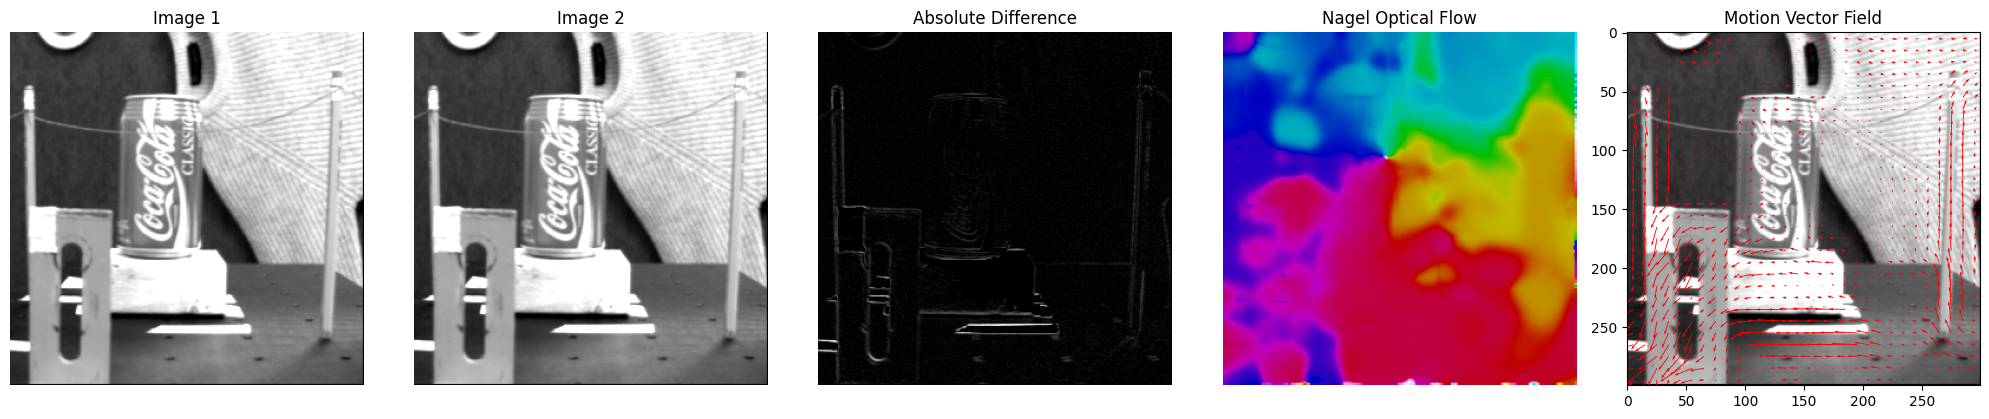

In [ ]:
# Load grayscale images (update the file paths as needed)
im1 = cv2.imread('/content/data/nasa/nasa10.png', cv2.IMREAD_GRAYSCALE)
im2 = cv2.imread('/content/data/nasa/nasa9.png', cv2.IMREAD_GRAYSCALE)
im1 = im1.astype(np.float32) / 255.0
im2 = im2.astype(np.float32) / 255.0

# --- Visualize the input images and their absolute difference
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

axs[0].imshow(im1, cmap='gray')
axs[0].set_title('Image 1')
axs[0].axis('off')

axs[1].imshow(im2, cmap='gray')
axs[1].set_title('Image 2')
axs[1].axis('off')

diff = np.abs(im2.astype(np.float32) - im1.astype(np.float32))
axs[2].imshow(diff, cmap='gray')
axs[2].set_title('Absolute Difference')
axs[2].axis('off')

# --- Run the Nagel method to compute the optical flow.
# Adjust parameters (N, alpha, delta) as desired.
N = 100       # number of iterations
alpha = 0.9   # regularization parameter
delta = 0.1   # oriented regularization parameter

# The nagel_method function returns the horizontal (u) and vertical (v) flow components.
u, v = nagel_method(im1, im2, N=N, alpha=alpha, delta=delta)

# Stack the two flow components to form a flow field (H x W x 2)
flow = np.stack((u, v), axis=-1)

# --- Convert the computed flow to a color image for visualization.
flow_color = computeColor(flow)

axs[3].imshow(flow_color)
axs[3].set_title('Nagel Optical Flow')
axs[3].axis('off')

# Display MVF using displayMVF
displayMVF(im1, flow, 10, ax=axs[4])

plt.tight_layout()
plt.show()


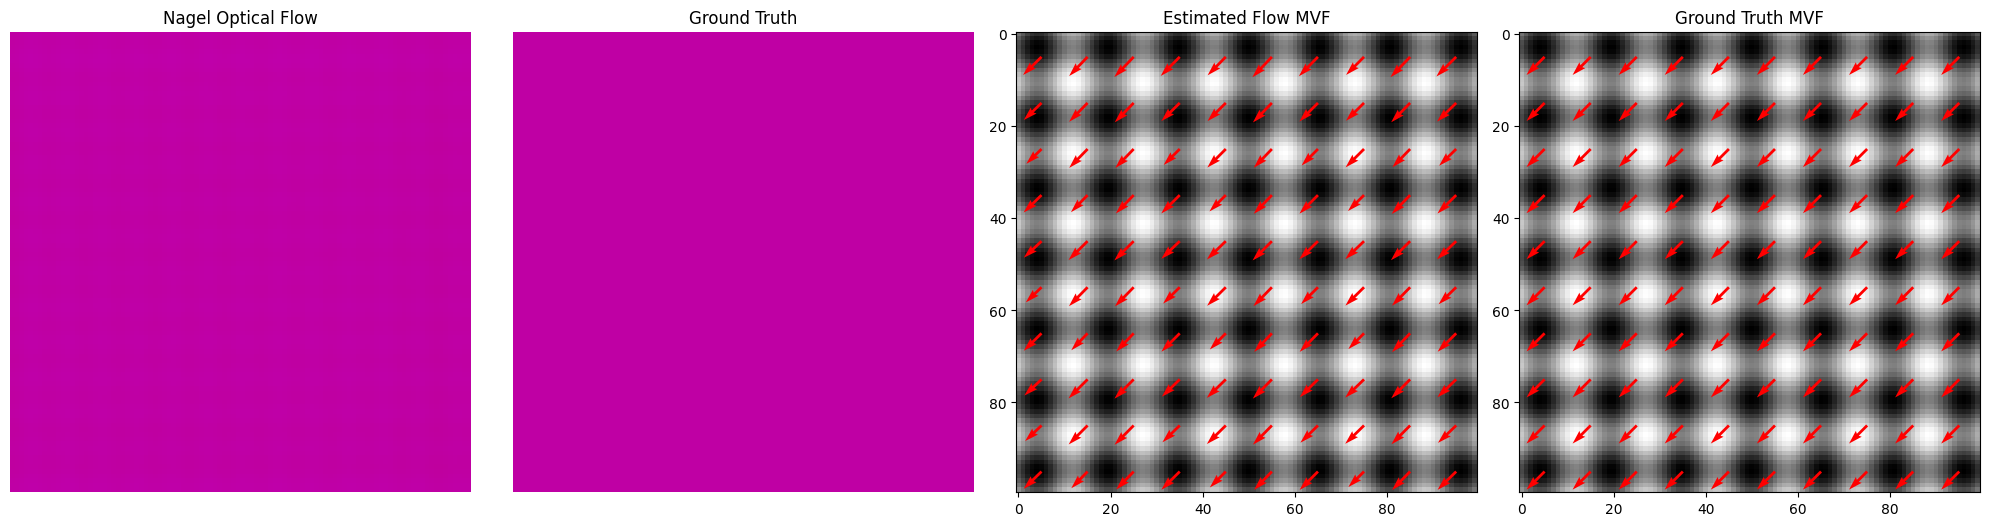

Angular Error: Mean=35.180782318115234, Std=0.013396549969911575
Norm Error: Mean=-438.40771484375, Std=26.539125442504883
End-Point Error: Mean=438.40771484375, Std=26.539125442504883


In [ ]:
# Load grayscale images (update the file paths as needed)
im1 = cv2.imread('/content/data/mysine/mysine9.png', cv2.IMREAD_GRAYSCALE)
im2 = cv2.imread('/content/data/mysine/mysine10.png', cv2.IMREAD_GRAYSCALE)
im1 = im1.astype(np.float32) / 255.0
im2 = im2.astype(np.float32) / 255.0

# --- Visualize the input images and their absolute difference
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# --- Run the Nagel method to compute the optical flow.
# Adjust parameters (N, alpha, delta) as desired.
N = 100       # number of iterations
alpha = 0.9   # regularization parameter
delta = 0.1   # oriented regularization parameter

# The nagel_method function returns the horizontal (u) and vertical (v) flow components.
u, v = nagel_method(im1, im2, N=N, alpha=alpha, delta=delta)

# Stack the two flow components to form a flow field (H x W x 2)
flow = np.stack((u, v), axis=-1)

# --- Convert the computed flow to a color image for visualization.
flow_color = computeColor(flow)

axs[0].imshow(flow_color)
axs[0].set_title('Nagel Optical Flow')
axs[0].axis('off')

# Plot ground truth
gt_flo = readflo('/content/data/mysine/correct_mysine.flo')
axs[1].imshow(computeColor(gt_flo))
axs[1].set_title('Ground Truth')
axs[1].axis('off')

# Display MVF for estimated flow and ground truth
displayMVF(im1, flow, 10, ax=axs[2])
axs[2].set_title('Estimated Flow MVF')

displayMVF(im1, gt_flo, 10, ax=axs[3])
axs[3].set_title('Ground Truth MVF')

plt.tight_layout()
plt.show()

# Compute errors and print
errors = compute_errors(gt_flo, flow)
print(f"Angular Error: Mean={errors[0][0]}, Std={errors[0][1]}")
print(f"Norm Error: Mean={errors[1][0]}, Std={errors[1][1]}")
print(f"End-Point Error: Mean={errors[2][0]}, Std={errors[2][1]}")

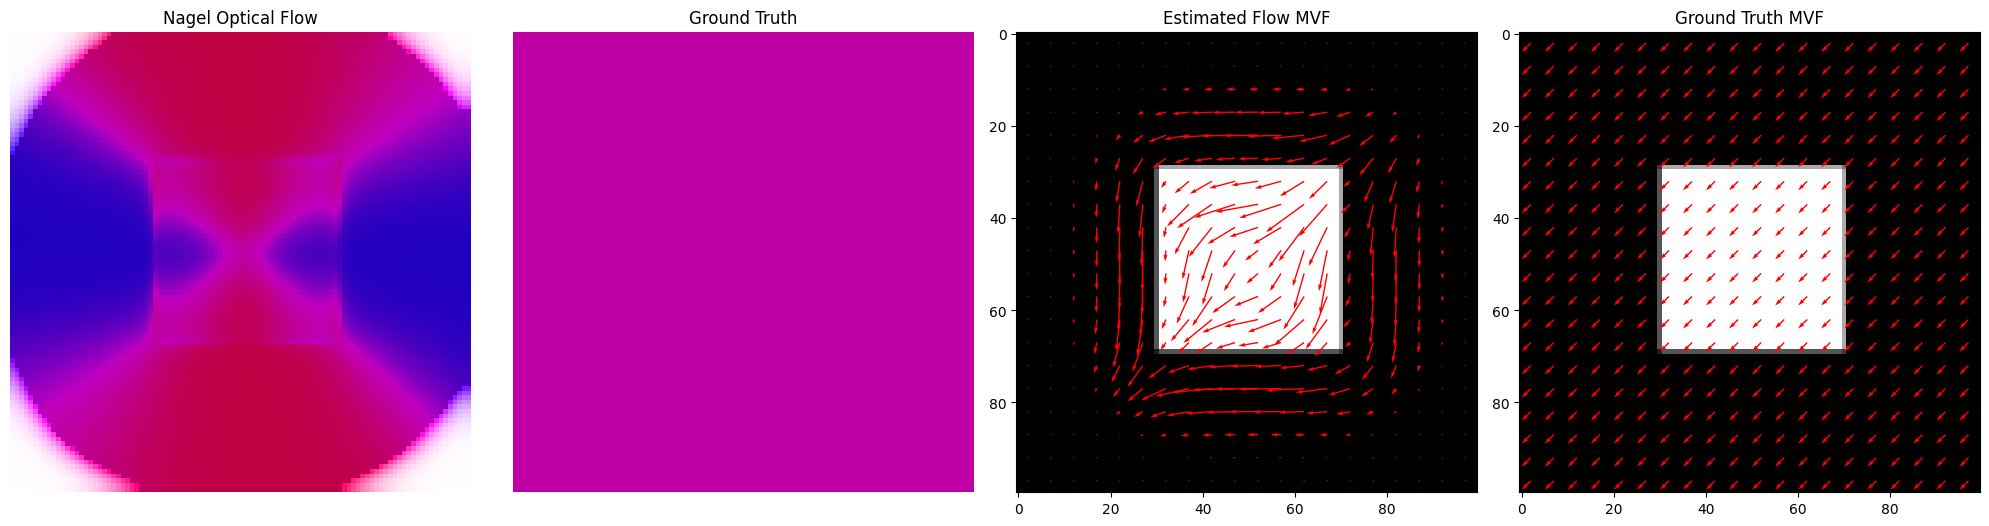

Angular Error: Mean=40.17600631713867, Std=10.325098991394043
Norm Error: Mean=-116.08892822265625, Std=162.83248901367188
End-Point Error: Mean=116.50982666015625, Std=162.53158569335938


In [ ]:
# Load grayscale images (update the file paths as needed)
im1 = cv2.imread('/content/data/square/square9.png', cv2.IMREAD_GRAYSCALE)
im2 = cv2.imread('/content/data/square/square10.png', cv2.IMREAD_GRAYSCALE)
im1 = im1.astype(np.float32) / 255.0
im2 = im2.astype(np.float32) / 255.0

# --- Visualize the input images and their absolute difference
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# --- Run the Nagel method to compute the optical flow.
# Adjust parameters (N, alpha, delta) as desired.
N = 100       # number of iterations
alpha = 0.9   # regularization parameter
delta = 0.1   # oriented regularization parameter

# The nagel_method function returns the horizontal (u) and vertical (v) flow components.
u, v = nagel_method(im1, im2, N=N, alpha=alpha, delta=delta)

# Stack the two flow components to form a flow field (H x W x 2)
flow = np.stack((u, v), axis=-1)

# --- Convert the computed flow to a color image for visualization.
flow_color = computeColor(flow)

axs[0].imshow(flow_color)
axs[0].set_title('Nagel Optical Flow')
axs[0].axis('off')

# Plot ground truth
gt_flo = readflo('/content/data/square/correct_square.flo')
axs[1].imshow(computeColor(gt_flo))
axs[1].set_title('Ground Truth')
axs[1].axis('off')

# Display MVF for estimated flow and ground truth
displayMVF(im1, flow, 5, ax=axs[2])
axs[2].set_title('Estimated Flow MVF')

displayMVF(im1, gt_flo, 5, ax=axs[3])
axs[3].set_title('Ground Truth MVF')

plt.tight_layout()
plt.show()

# Compute errors and print
errors = compute_errors(gt_flo, flow)
print(f"Angular Error: Mean={errors[0][0]}, Std={errors[0][1]}")
print(f"Norm Error: Mean={errors[1][0]}, Std={errors[1][1]}")
print(f"End-Point Error: Mean={errors[2][0]}, Std={errors[2][1]}")

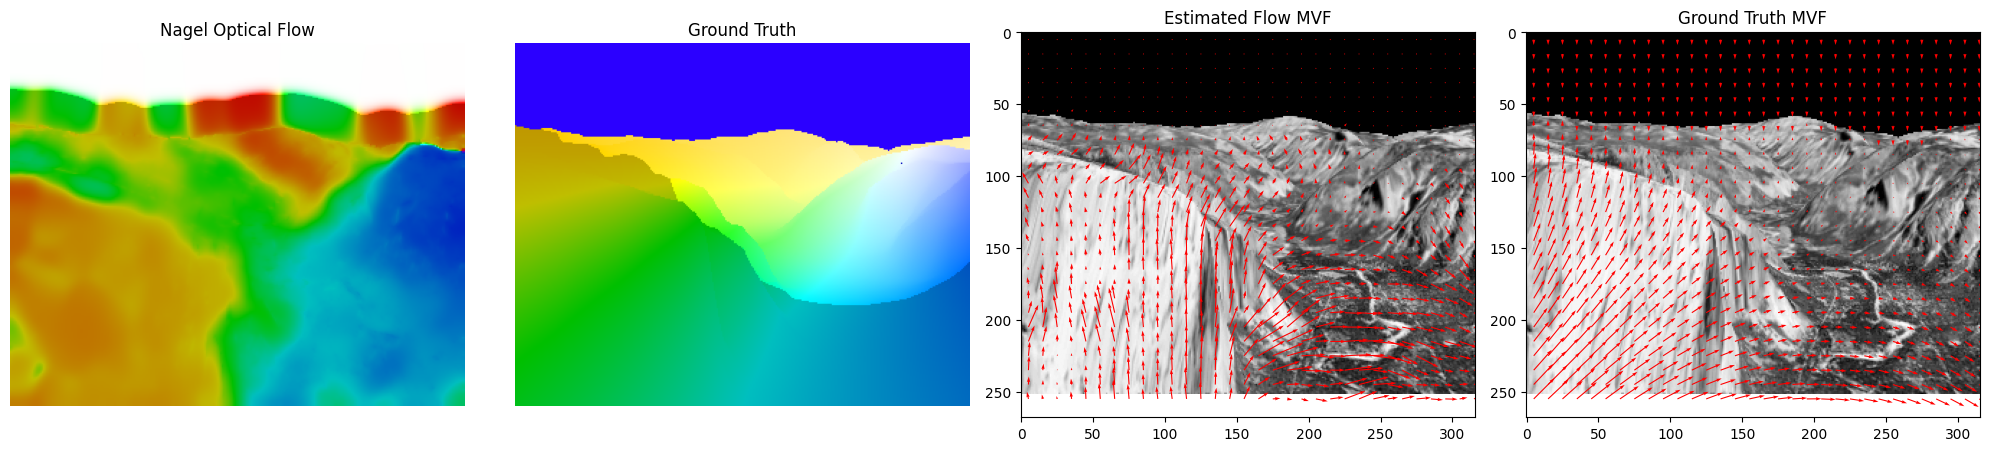

Angular Error: Mean=56.491050720214844, Std=24.30769920349121
Norm Error: Mean=-138.29310607910156, Std=165.72097778320312
End-Point Error: Mean=138.94349670410156, Std=165.2694854736328


In [ ]:
# Load grayscale images (update the file paths as needed)
im1 = cv2.imread('/content/data/yosemite/yos9.png', cv2.IMREAD_GRAYSCALE)
im2 = cv2.imread('/content/data/yosemite/yos10.png', cv2.IMREAD_GRAYSCALE)
im1 = im1.astype(np.float32) / 255.0
im2 = im2.astype(np.float32) / 255.0

# --- Visualize the input images and their absolute difference
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# --- Run the Nagel method to compute the optical flow.
# Adjust parameters (N, alpha, delta) as desired.
N = 100       # number of iterations
alpha = 0.9   # regularization parameter
delta = 0.1   # oriented regularization parameter

# The nagel_method function returns the horizontal (u) and vertical (v) flow components.
u, v = nagel_method(im1, im2, N=N, alpha=alpha, delta=delta)

# Stack the two flow components to form a flow field (H x W x 2)
flow = np.stack((u, v), axis=-1)

# --- Convert the computed flow to a color image for visualization.
flow_color = computeColor(flow)

axs[0].imshow(flow_color)
axs[0].set_title('Nagel Optical Flow')
axs[0].axis('off')

# Plot ground truth
gt_flo = readflo('/content/data/yosemite/correct_yos.flo')
axs[1].imshow(computeColor(gt_flo))
axs[1].set_title('Ground Truth')
axs[1].axis('off')

# Display MVF for estimated flow and ground truth
displayMVF(im1, flow, 10, ax=axs[2])
axs[2].set_title('Estimated Flow MVF')

displayMVF(im1, gt_flo, 10, ax=axs[3])
axs[3].set_title('Ground Truth MVF')

plt.tight_layout()
plt.show()

# Compute errors and print
errors = compute_errors(gt_flo, flow)
print(f"Angular Error: Mean={errors[0][0]}, Std={errors[0][1]}")
print(f"Norm Error: Mean={errors[1][0]}, Std={errors[1][1]}")
print(f"End-Point Error: Mean={errors[2][0]}, Std={errors[2][1]}")